In [12]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2 as cv
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToTensor

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix

import pylab as pl
from IPython import display
from tqdm import tqdm

torch.manual_seed(33)

In [13]:
import pandas as pd

images_path = 'images/'
annotations_path = 'annotations/list.txt'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=columns)

df["Image"] = images_path + df["Image"] + '.jpg'
df["CLASS-ID"] = df["CLASS-ID"].astype('int64')
df["SPECIES"] = df["SPECIES"].astype('int64')
df["BREED ID"] = df["BREED ID"].astype('int64')

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x - 1)

print(df)

                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


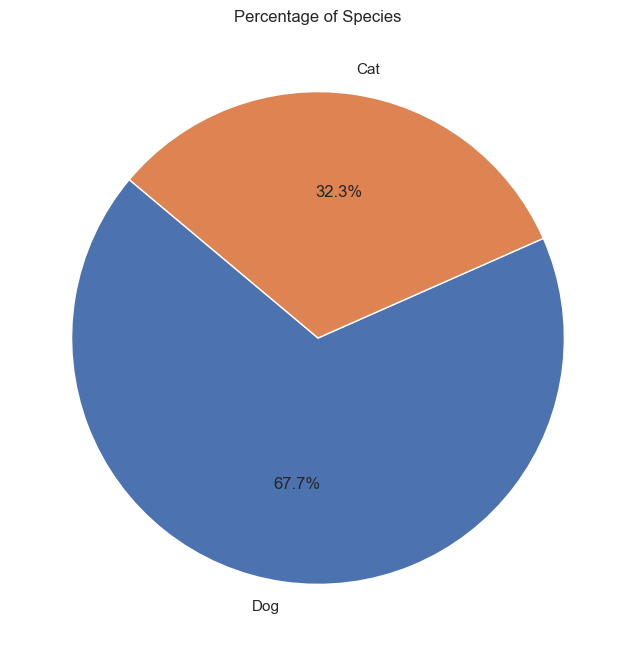

In [14]:
species_counts = df['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

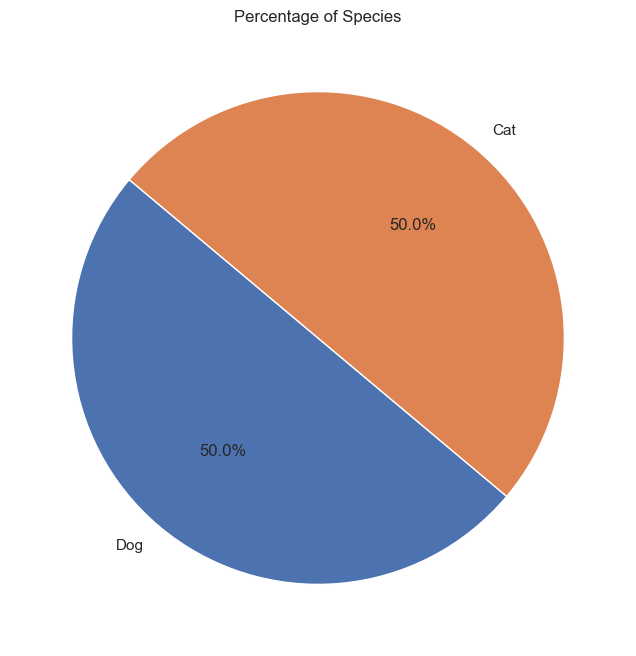

In [15]:
cats_df = df[df['SPECIES'] == 0]
dogs_df = df[df['SPECIES'] == 1]

min_samples = min(len(cats_df), len(dogs_df))
cats_sampled = cats_df.sample(n=min_samples, random_state=42)
dogs_sampled = dogs_df.sample(n=min_samples, random_state=42)

df_balanced = pd.concat([cats_sampled, dogs_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


species_counts = df_balanced['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

### OUR CNN

In [16]:
X = df_balanced[["Image"]]
y = df_balanced[["SPECIES"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['SPECIES'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['SPECIES'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

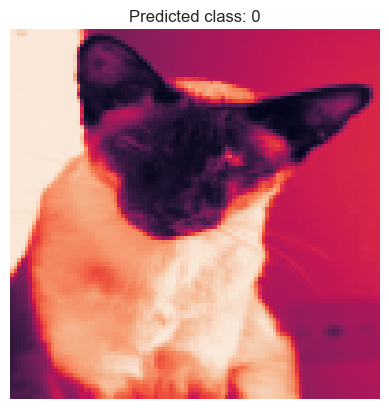

Etiqueta: 0
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [17]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.title(f"Predicted class: {labels[0].item()}")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [18]:
from collections import OrderedDict

class SuperCNNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SuperCNNSuperGuay, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, 5, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(24*6*6, 200)
        self.linear_2 = nn.Linear(200, 10)
        self.linear_3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv_1(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_2(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_3(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_4(x)
        x = self.max_pool2d(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_2(x)
        x = self.relu(x)

        x = self.linear_3(x)

        return F.log_softmax(x, dim=1)
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [

                ]
            )
        )
    
class SuperFCNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, init_features=32):
        super(SuperFCNSuperGuay, self).__init__()
        
      
        # Encoder layers (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Decoder layers (upsampling)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder (downsampling)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Decoder (upsampling)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)

        # Apply sigmoid activation for binary classification
        x = self.sigmoid(x)

        return x

In [19]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = SuperFCNSuperGuay().to(device)

epochs = 5
lr = 1e-3

optimizer = Adam(model.parameters(), lr=lr)

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        input_img= input_img.to(device)
        optimizer.zero_grad()     
        
        target = target.to(device)
        output = model(input_img)
        print(output.shape)
    
        loss = F.binary_cross_entropy(output.view(-1), target.float())
        loss.backward()                                            
        
        optimizer.step()                                               
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in test_dl: 
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = F.cross_entropy(output, target, reduction='sum') 
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_dl)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(test_dl)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

  0%|          | 0/5 [00:05<?, ?it/s]

torch.Size([64, 1, 800, 800])


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([40960000])) is deprecated. Please ensure they have the same size.

In [ ]:
from sklearn.metrics import confusion_matrix

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

            # Collect true and predicted labels for the confusion matrix
            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

        accuracy = num_correct / num_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

    model.train()
    
    class_names = list(set(all_true_labels + all_predicted_labels))

    sns.heatmap(confusion_matrix(all_true_labels, all_predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2, bias=True)
        )
    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModel()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class_mapping = {0: 'Cat', 1: 'Dog'}

import random

# Get the maximum index in the DataFrame
max_index = len(df) - 1

# Generate a random index between 1 and max_index
i = random.randint(1, max_index)

# Load an image from a file path
image_path = df.iloc[i]['Image']
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


### Proves amb fotos a local

In [ ]:
# Load an image from a file path
image_path = 'C:/Users/marti/Downloads/ema2.jpeg'
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


# Apartat 2

In [50]:
X = df_balanced[["Image"]]
y = df_balanced[["CLASS-ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['CLASS-ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['CLASS-ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

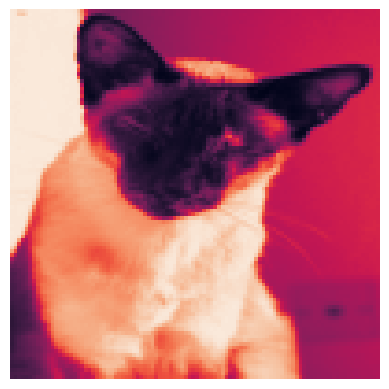

Etiqueta: 32
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [51]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=37, bias=True)
        )

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-5
num_epochs = 35

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

## Second Approach

### Cat breed classifier

In [65]:
# print(cats_df)
X = cats_df[["Image"]]
y = cats_df[["BREED ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['BREED ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['BREED ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

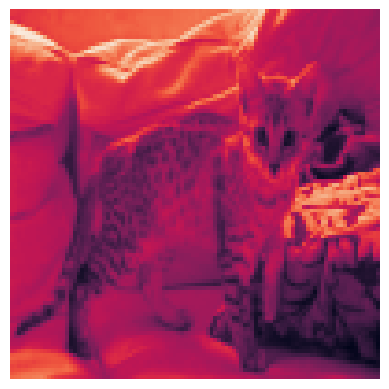

Etiqueta: 5
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [68]:
features, label = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {label[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label.size()}")

In [69]:


class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelCatBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=37, bias=True)
        )

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

Inception loaded


In [ ]:
learning_rate = 1e-5
num_epochs = 35

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

# Apartat 3: Segmentació dels animals

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

In [ ]:
model = torch.hub.load("yolov5/","yolov5x", source="local")  

In [ ]:
# Accepta URL, path, PIL, OpenCV, numpy o una llista
img = "images/Abyssinian_106.jpg"

In [ ]:
# Inferencia
results = model(img)

# Resultats
results.show()  # mètode de la classe detections

In [ ]:
results.pandas().xyxy[0]

In [ ]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
# Convert a pytorch tensor into a PIL image
t2img = transform.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = transform.ToTensor()


def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

In [ ]:
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
ruta_trimap = 'annotations/trimaps/Abyssinian_1.png'
ruta_img = 'images/Abyssinian_1.jpg'
trimap = cv.imread(ruta_trimap, cv.IMREAD_GRAYSCALE)
img = cv.imread(ruta_img)
t2img(trimap2f(trimap))


In [ ]:
import glob
import json
import cv2
# https://www.youtube.com/watch?v=NYeJvxe5nYw
# Label IDs of the dataset representing different categories
category_ids = {
    "pet" : 0,
    "background" : 1,
    "border" : 2,
}

MASK_EXT = 'png'
ORIGINAL_EXT = 'jpg'
image_id = 0
annotation_id = 0

def images_annotations_info(maskpath):
    """
    Process the binary masks and generate images and annotations information.

    :param maskpath: Path to the directory containing binary masks
    :return: Tuple containing images info, annotations info, and annotation count
    """
    global image_id, annotation_id
    annotations = []
    images = []

    # Iterate through categories and corresponding masks
    for category in category_ids.keys():
        for mask_image in glob.glob(os.path.join(maskpath, category, f'*.{MASK_EXT}')):
            original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
            mask_image_open = cv2.imread(mask_image)
            
            # Get image dimensions
            height, width, _ = mask_image_open.shape

            # Create or find existing image annotation
            if original_file_name not in map(lambda img: img['file_name'], images):
                image = {
                    "id": image_id + 1,
                    "width": width,
                    "height": height,
                    "file_name": original_file_name,
                }
                images.append(image)
                image_id += 1
            else:
                image = [element for element in images if element['file_name'] == original_file_name][0]

            # Find contours in the mask image
            gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

            # Create annotation for each contour
            for contour in contours:
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)
                segmentation = contour.flatten().tolist()

                annotation = {
                    "iscrowd": 0,
                    "id": annotation_id,
                    "image_id": image['id'],
                    "category_id": category_ids[category],
                    "bbox": bbox,
                    "area": area,
                    "segmentation": [segmentation],
                }

                # Add annotation if area is greater than zero
                if area > 0:
                    annotations.append(annotation)
                    annotation_id += 1

    return images, annotations, annotation_id


def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

if __name__ == "__main__":
    train_mask_path = "annotations/trimaps/"
    train_json_path = "annotations/trimaps_train.json"
    process_masks(train_mask_path, train_json_path)

    val_mask_path = "annotations/trimaps/"
    val_json_path = "annotations/trimaps_train.json"
    process_masks(val_mask_path, val_json_path)